In [1]:
# HINTS with numpy
#%load_ext line_profiler
import numpy as np
from HINTS import *
from HINTS_fn import *
#import cython # TO DO

In [2]:
# NB the proposed state must not share memory with the original state (because we hash when we cache)
def proposal1(state, index):
    return(state + randn(state.shape[0]), 0.0) # new state, optional evaluation at new state, correction for asymmetry  



In [3]:
# test the  Test function
xs = np.arange(-2.0, 2.0, 0.001)
shuffle(xs) # so noise is random
e = TestFn(proposal1, xs.size)
f = e.evaluate

hxs = [HashableItem(np.array([x])) for x in xs]

%time ys = [f(x, i, 0) for i, x in enumerate(hxs)]
print(e.counter)
%time ys = [f(x, i, 0) for i, x in enumerate(hxs)]
print(e.counter)
%time ys = [f(x, i, 0) for i, x in enumerate(hxs)]
print(e.counter)
%time ys = [e.user_evaluate((x,), i, 0) for i, x in enumerate(xs)]
print(e.counter)

Wall time: 21.5 ms
4000
Wall time: 2 ms
4000
Wall time: 3.99 ms
4000
Wall time: 15 ms
8000


In [4]:
import argparse
parser = argparse.ArgumentParser()
args = parser.parse_known_args()[0] # defaults

# checked regular MCMC is accurate (1 level, lbf = 6)
if True:
    args.levels = 8
    log_branch_factor = 1
    N_0 = 1
    args.design = np.array([N_0] + [2 ** log_branch_factor for l in range(args.levels)])
    NUM_SCENARIOS = N_0 * 2 ** (args.levels * log_branch_factor) # TO DO get from HINTS
else: #MCMC
    args.levels = 0
    NUM_SCENARIOS = 256
    args.design = np.array([NUM_SCENARIOS])

print(NUM_SCENARIOS)

# design now has levels + 1 entries

# additive log probability is more natural from a Bayesian perspective but both are valid

args.additive = True # effectively selects a different temperature structure when False (= average or expectation)

args.T = 1.0 #top level
args.dT = 0.0 if args.additive else 0.5 # temperature increment by level (mainly for optimisation or averaging structure)

print(args.__dict__)

256
{'levels': 8, 'design': array([1, 2, 2, 2, 2, 2, 2, 2, 2]), 'additive': True, 'T': 1.0, 'dT': 0.0}


In [5]:

g = TestFn(proposal1, NUM_SCENARIOS, args.additive)
hmc = HINTS(args, g)
state  = g.sample_initial_state()
print(state)

nsd = 4.0 # for diagnostics only
bins = 64

histogram = np.zeros([bins], dtype = float)

#%timeit hmc.shuffle() # negligible
#%timeit hmc.hints(state,  levels, index = 0, T = 1.0, dbg = False) # e.g. dbg = (t==0)


RESET
8
[  1   2   4   8  16  32  64 128 256]
256
[1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [6]:
for t in range(5000):
    hmc.shuffle()
    state, correction = hmc.hints(state, args.levels) # e.g. dbg = (t==0)
    # diagnostic histogram
    if (abs(state.x[0]) < nsd): # ignoring samples outside diagnostic range
        j = int((state.x[0] + nsd) * bins/(2.0 * nsd))
        histogram[j] += 1.0
    # show progress
    if ((t%500)==499):
        print(t+1)

500
1000
1500
2000
2500
3000
3500
4000
4500
5000


In [7]:
print(histogram)
print(hmc.acceptances)
print(hmc.rejections)
print(hmc.acceptances / (hmc.acceptances + hmc.rejections))

[  0.   1.   0.   0.   0.   2.   1.   0.   2.   4.   3.   7.  13.  18.
  15.  28.  38.  49.  57.  59.  69. 121. 120. 134. 161. 188. 182. 227.
 227. 243. 249. 281. 303. 234. 237. 217. 178. 174. 190. 165. 159. 109.
 102.  98.  74.  50.  60.  40.  33.  15.  14.  14.  18.   8.   2.   1.
   3.   1.   0.   1.   1.   0.   0.   0.]
[1273093  634949  312742  150739   69943   32332   15626    7810    3949]
[ 6907  5051  7258  9261 10057  7668  4374  2190  1051]
[0.99460391 0.99210781 0.97731875 0.94211875 0.8742875  0.8083
 0.7813     0.781      0.7898    ]


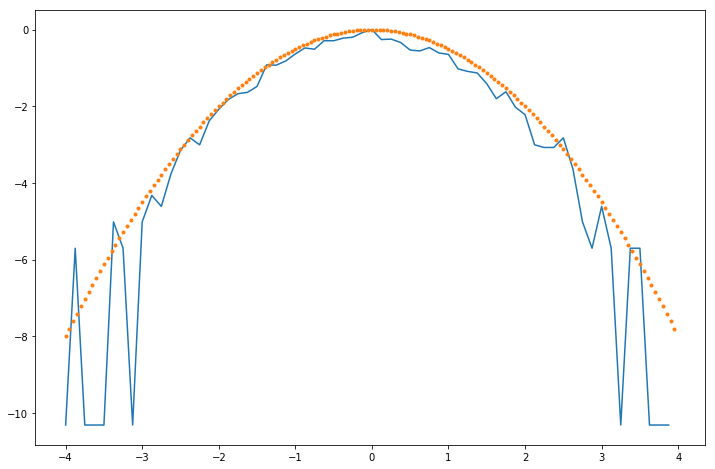

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt # just for testing

#plt.plot(histogram)
fig = plt.figure(figsize=[12,8])
ax1 = plt.gca()
xs1 = np.arange(bins, dtype = float) * (2.0 * nsd)/bins - nsd 

logprob = np.log(histogram + 0.01)

plt.plot(xs1, logprob - np.max(logprob))
xs = np.arange(-nsd, nsd, nsd/80.0)
shuffle(xs) # so noise is not correlated with term

hxs = [HashableItem(np.array([x])) for x in xs]

# do not create a new test function here... use the same one
if args.additive:
    ys = [sum([g.evaluate(x, i, 0) for i in range(NUM_SCENARIOS)]) for x in hxs]
else:
    ys = [sum([g.evaluate(x, i, 0)/NUM_SCENARIOS for i in range(NUM_SCENARIOS)]) for x in hxs]

plt.plot(xs, ys,'.')


In [9]:
print('Calls: {:,}; '.format(g.total_counter) + 'Missed cache: {:,}; '.format(g.counter) + 'Miss rate: {}%'.format(int((100.0 * g.counter)/g.total_counter)))

Calls: 23,080,960; Missed cache: 20,447,197; Miss rate: 88%


In [10]:
# TO DO 
# pytorch test function
# state is model
# proposal is grad descent + noise (Langevin or HMC style) on minibatch
# SEE HINTS_fn_torch.py